## Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [2]:
AMOUNT_OF_SENSORS = 3
VALIDATION_TESTSET = "004"

## Datapreparation

#### Train

In [3]:
x_train_arr = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

### Test


In [4]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]
x_test_dict.pop(VALIDATION_TESTSET)
y_test_dict.pop(VALIDATION_TESTSET)

0       1
1       1
2       1
3       1
4       1
       ..
8362    2
8363    2
8364    2
8365    2
8366    2
Name: Pose, Length: 8367, dtype: int64

## Visualisation

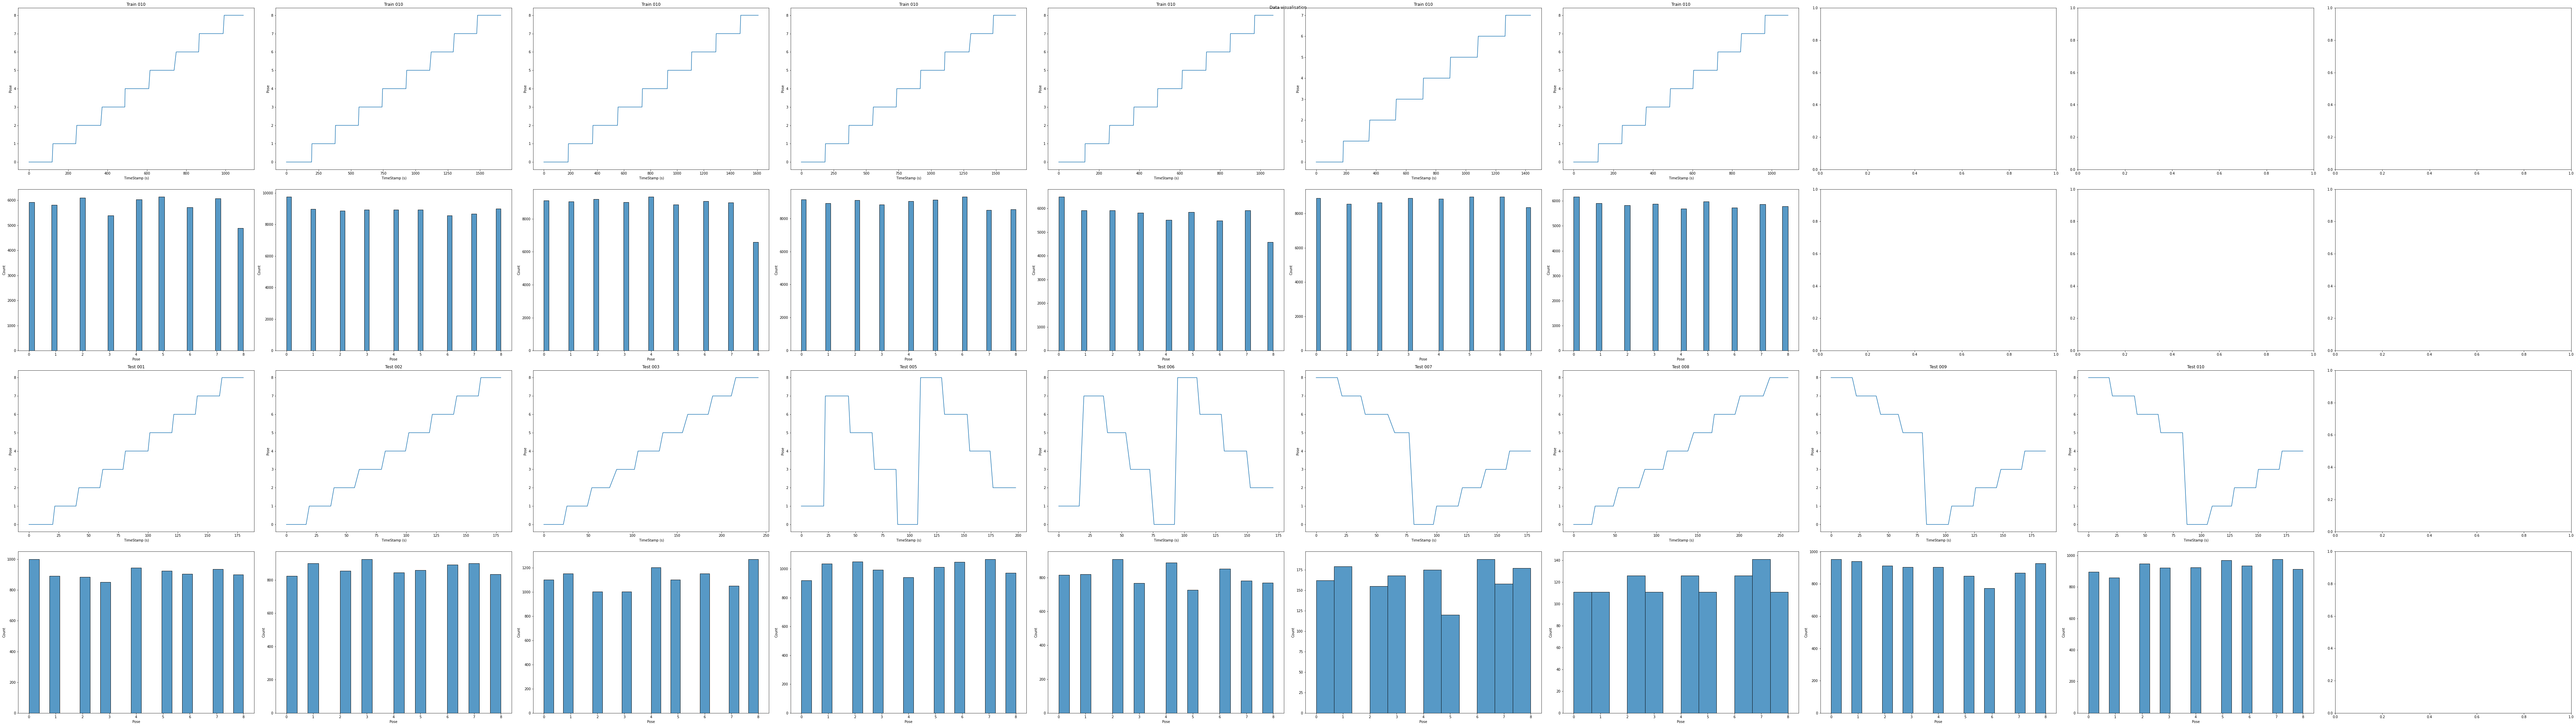

In [5]:
cols = []
height=30
width=(height/2)*len(x_train_arr)
fig, axes = plt.subplots(4,  max(len(training_files), len(testing_files)), figsize=(width, height))
fig.suptitle('Data visualisation')
# Train
for i in range(len(x_train_arr)):
    sns.lineplot(ax=axes[0, i], data=x_train_arr[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=x_train_arr[i].df["Pose"])
    cols.append(f'Train {key}')    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
# Test
cols=[]
for i, key in enumerate(x_test_dict):
    sns.lineplot(ax=axes[2, i], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols.append(f'Test {key}')
for ax, col in zip(axes[2], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [6]:
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

### GridSearch

## RFC            

## Precision

In [7]:
# Evaluation methods
import math
import numpy
from sklearn.model_selection import KFold,RepeatedStratifiedKFold, cross_val_score

def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores


def evaluate_w_validation_set(model, x, y):
    model.fit(x, y)
    classifications = model.predict(x_test)
    annotated_positions = y_test.to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    accuracy = round(correct_classifications/len(classifications)*100,2)

    return accuracy


def find_oob_err(max_features=None, max_samples=None, n_estimators=10):
    rfc = RandomForestClassifier(n_estimators=i, max_features=max_features, oob_score=True, random_state=33, max_samples=max_samples)
    rfc.fit(x_train, y_train)
    print("rfc oob_score: ", rfc.oob_score_)
    err = 1-rfc.oob_score_
    
    print("1-oob_score: ", err)
    return err


def find_test_accuracy(model, x, y):
    model.fit(x_train, y_train)
    print("Classification accuracy:")
    classification_dict = dict()
    accuracy_list = list()

    for key in x_test_dict:
        x_test = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
        classifications = model.predict(x_test)
        annotated_positions = y_test_dict[key].to_numpy()
        correct_classifications = (classifications == annotated_positions).sum()
        accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
        print(f"{key}: {accuracy_list[-1]}%")
        classification_dict[key] = classifications

    avg = round(sum(accuracy_list)/len(accuracy_list),2)
    print(f"Average accuracy: {avg}%\nWith {estimators} estimators and\nrandom_state={33}")
    return avg


best_featue_amount:  4


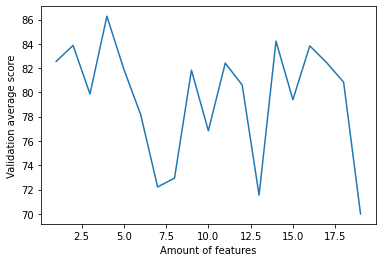

In [8]:
# Find best amount of features with cross_validation
def get_models_features(n_estimators=10):
	models = dict()
	# explore number of features
	for i in range(1, math.ceil(((AMOUNT_OF_SENSORS*13)+1)/2)):
		models[str(i)] = RandomForestClassifier(max_features=i, n_estimators=n_estimators, random_state=33)
	return models


feature_models = get_models_features()
feature_val_scores = []
for i in range(len(feature_models)):
    feature_val_score = evaluate_w_validation_set(feature_models[str(i+1)], x_train, y_train)
    feature_val_scores.append(feature_val_score)
best_feature_amount = feature_val_scores.index(max(feature_val_scores))+1
print("best_featue_amount: ", best_feature_amount)

plt.plot([i for i in range(1,len(feature_val_scores)+1)], feature_val_scores)
plt.xlabel("Amount of features")
plt.ylabel("Validation average score")
plt.show()

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
None
best_sample_amount:  0.6


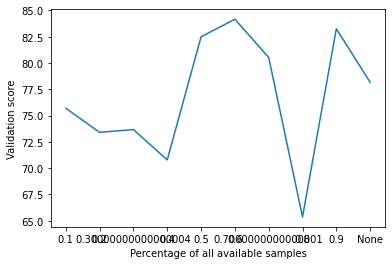

In [9]:
# Find best amount of samples for dataset
import numpy
def get_models_samples(n_estimators=10, max_features=None):
    models = dict()
    # explore ratios from 10% to 100% in 10% increment
    for i in numpy.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        # set max_samples=None to use 100%
        if i == 1.0:
            i = None
        models[str(i)] = RandomForestClassifier(max_samples=i, random_state=33, n_estimators=n_estimators)
        print(i)
    return models

sample_models = get_models_samples()
samples_val_scores = []
for samples, model in sample_models.items():
    val_score = evaluate_w_validation_set(model, x_train, y_train)
    samples_val_scores.append(val_score)
best_sample_amount = float(list(sample_models.keys())[samples_val_scores.index(max(samples_val_scores))])
print("best_sample_amount: ", best_sample_amount)
 
plt.plot(list(sample_models.keys()), samples_val_scores)
plt.xlabel("Percentage of all available samples")
plt.ylabel("Validation score")
plt.show()

In [10]:
# Find best rfc overall
"""def get_models_estimators(max_features=None, max_samples=None):
    models = dict()
    for i in range(1, 162, 20):
        models[str(i)] = RandomForestClassifier(max_features=max_features, max_samples=max_samples, n_estimators=i, random_state=33)
    return models

estimator_models = get_models_estimators(max_features=best_feature_amount, max_samples=best_sample_amount)
best_avg = 0
best_estimators = -1
best_model = None
for estimators, model in estimator_models.items():
    cv_score = evaluate_model(model, x_train, y_train)
    print(estimators, " ", cv_score)
    avg = sum(cv_score)/len(cv_score)
    if avg > best_avg:
        best_avg = avg
        best_estimators = estimators
        best_model = model

print(f"Best model with {best_feature_amount} features, {best_sample_amount} samplesize and {best_estimators} estimators")
print("yo")"""
best_model = RandomForestClassifier(random_state=33, max_features=best_feature_amount, max_samples=best_sample_amount, n_estimators=150)


In [11]:
# Make final model

final_model = best_model.fit(x_train, y_train)

print("Classification accuracy:")
classification_dict = dict()
accuracy_list = list()

for key in x_test_dict:
    x_test = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
    classifications = final_model.predict(x_test)
    annotated_positions = y_test_dict[key].to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
    print(f"{key}: {accuracy_list[-1]}%")
    classification_dict[key] = classifications

avg = round(sum(accuracy_list)/len(accuracy_list),2)
print(f"Average accuracy: {avg}%\nWith 150 estimators and\nrandom_state={33}")


Classification accuracy:
001: 86.53%
002: 80.49%
003: 88.58%
005: 78.1%
006: 80.31%
007: 85.16%
008: 33.24%
009: 81.68%
010: 78.66%
Average accuracy: 76.97%
With 150 estimators and
random_state=33


## Visualization


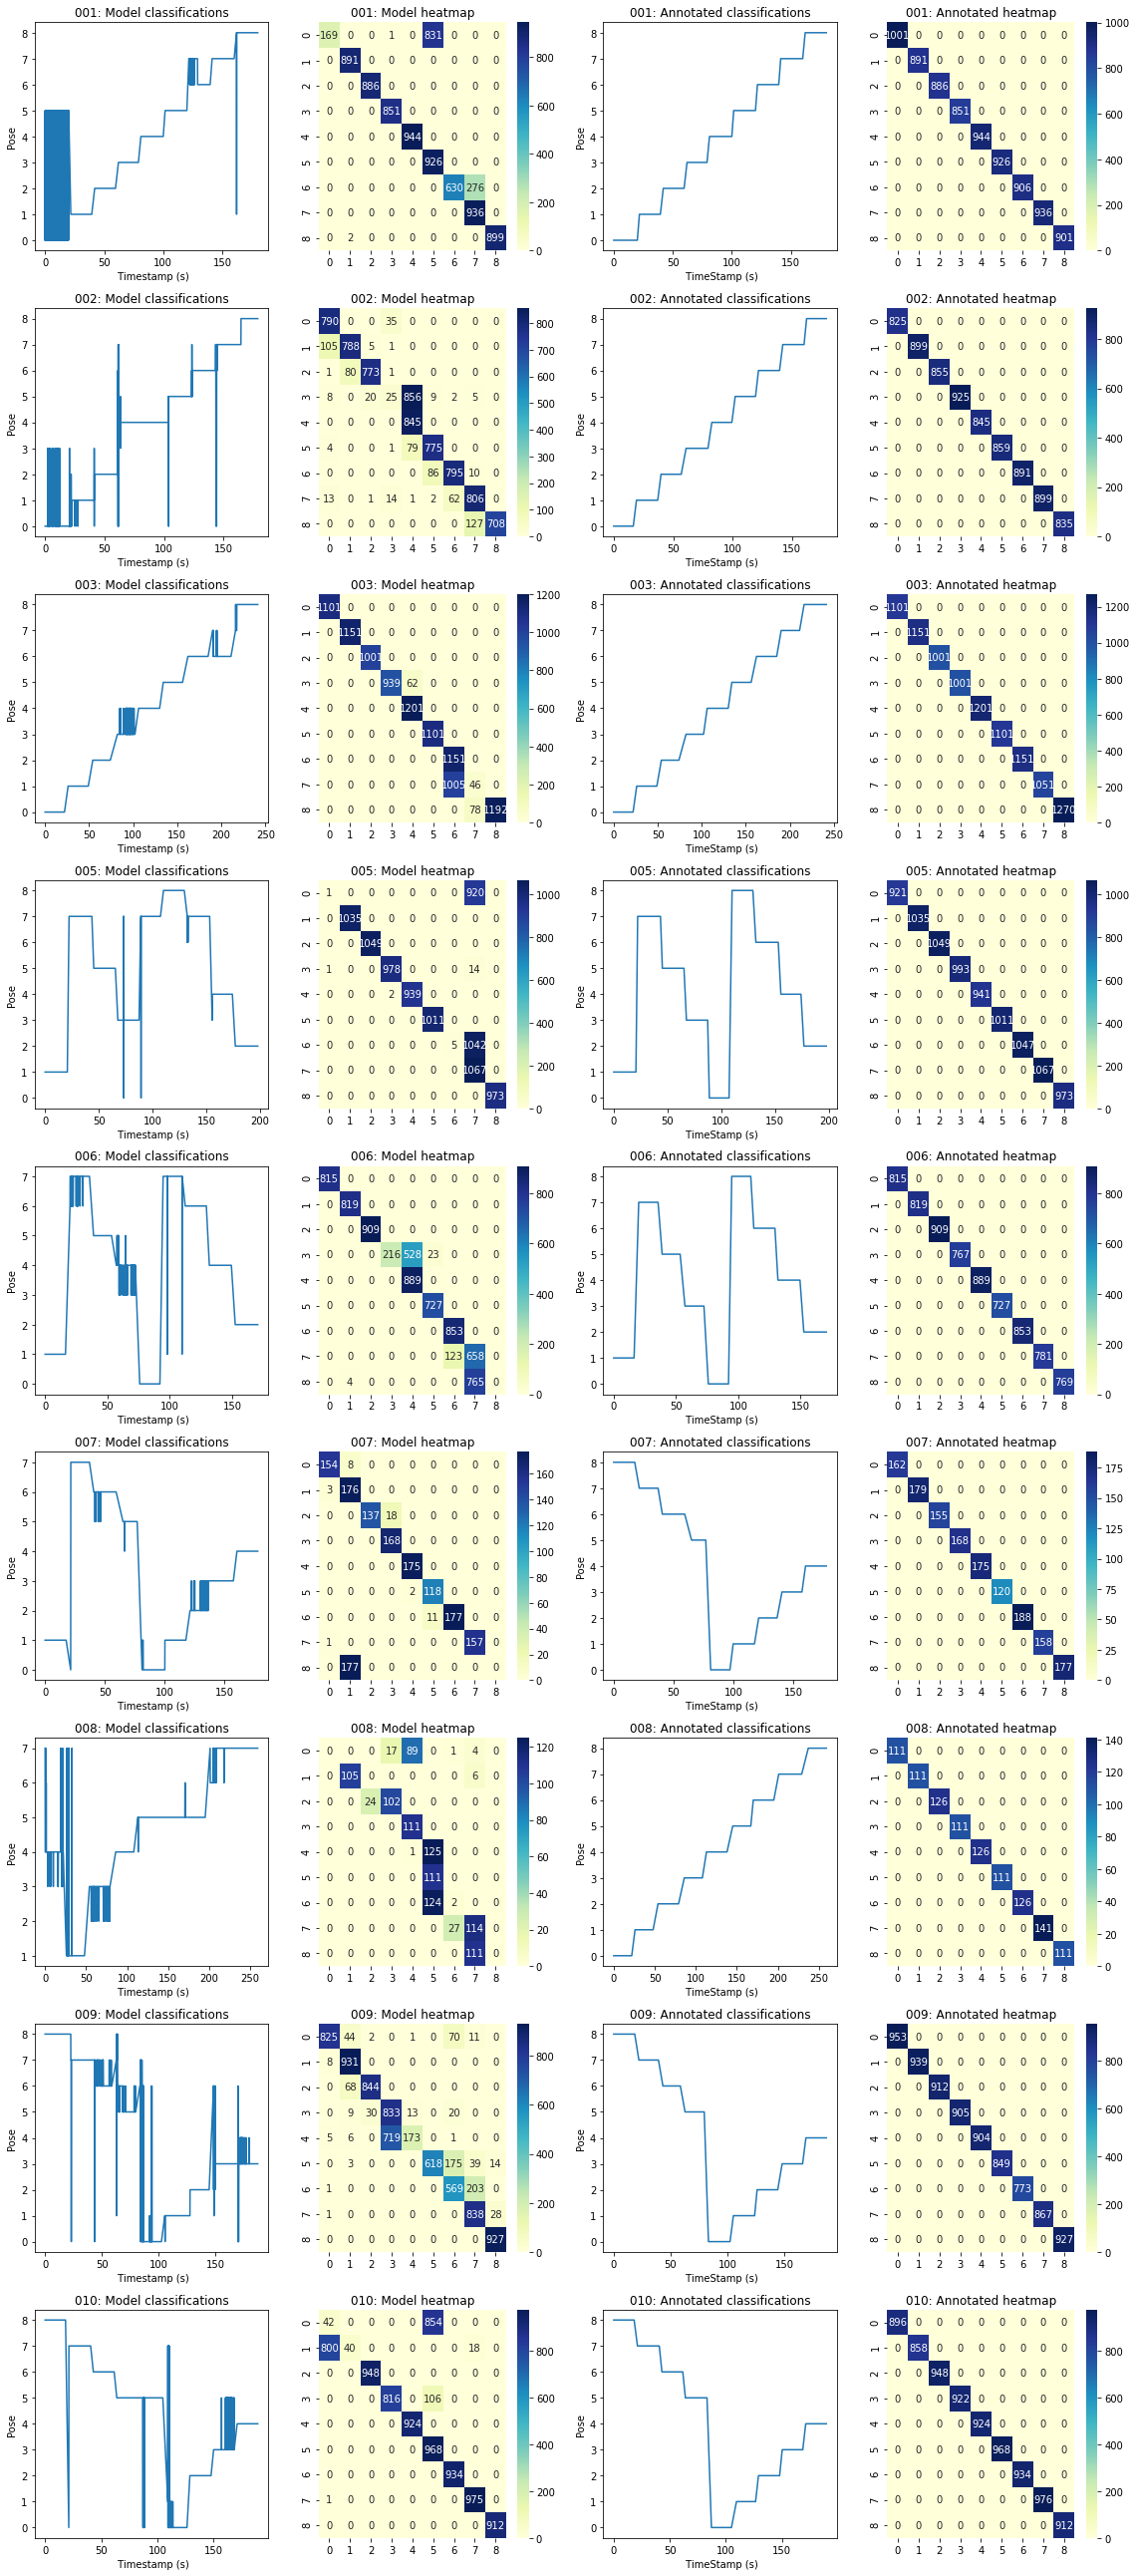

In [12]:
width=16
height=4*len(x_test_dict)
fig, axes = plt.subplots(len(x_test_dict), 4, figsize=(width, height))
for i, key in enumerate(x_test_dict):
    cols = [f"{key}: Model classifications", f"{key}: Model heatmap", f"{key}: Annotated classifications", f"{key}: Annotated heatmap"]
    df_predict = pd.DataFrame({' Timestamp (s)': x_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[i, 0], data=df_predict,x=' Timestamp (s)',y='Pose')
    sns.heatmap(ax=axes[i, 1], data=confusion_matrix(y_test_dict[key], classification_dict[key]), cmap="YlGnBu", annot=True, fmt="d")
    sns.lineplot(ax=axes[i, 2], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.heatmap(ax=axes[i, 3], data=confusion_matrix(y_test_dict[key], y_test_dict[key].to_numpy()), cmap="YlGnBu", annot=True, fmt="d")
    for ax, col in zip(axes[i], cols): ax.set_title(col)
fig.tight_layout()
plt.show()
fig.savefig(f"RFC_{AMOUNT_OF_SENSORS}_plot.png")

## Classification matrix and report

In [13]:
from joblib import dump, load
#dump(final_model, f'../models/RFC_model_{AMOUNT_OF_SENSORS}.joblib')


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>